In [1]:
# Importing the libraries we'll be using for this project
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, RocCurveDisplay,f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.utils.class_weight import compute_class_weight


In [3]:
# load in database and split as neccessary
df = pd.read_csv('database_prev7days.csv')
df = df[df.Diff != 0]
print(df.shape)
# Splitting the training data into appropriate training and validation sets
X = df.drop(columns = ["Diff","Date","Unnamed: 0"])
print(df.head(2))
y = df[['Diff']]
y = y.to_numpy().flatten()
weights = compute_class_weight(class_weight='balanced',classes = np.unique(y),y = y)

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 42,stratify=y)# makes sure train test splitting are the imbalanced by the same amount

(532, 38)
   Unnamed: 0    pos_sd  neu_mean    neu_sd  neg_mean    neg_sd  pos_sd.1  \
0           0  0.344085  0.400821  0.281704  0.098873  0.211905  0.289790   
1           1  0.306908  0.458364  0.306520  0.007969  0.005117  0.344085   

   neu_mean.1  neu_sd.1  neg_mean.1  ...  neu_sd.5  neg_mean.5  neg_sd.5  \
0    0.578190  0.254492    0.148739  ...  0.159680    0.084869  0.129022   
1    0.400821  0.281704    0.098873  ...  0.262761    0.229705  0.290300   

   pos_sd.6  neu_mean.6  neu_sd.6  neg_mean.6  neg_sd.6        Date  Diff  
0  0.296662    0.561700  0.321023    0.114403  0.286512  2014-01-09  -1.0  
1  0.180233    0.671139  0.159680    0.084869  0.129022  2014-01-10  -1.0  

[2 rows x 38 columns]


In [4]:
def cv_fit_search(pipeline, param_grid, X_train,y_train,X_test,y_test,cv):
    """ a function to fit the data and do hyper parameter tuning
    Args:
        pipeline: a predefined pipeline
        param grid: a list of parameters that match the pipeline naming convetion
        CV: integer indicating the number of cross validations we want to do
        X_train:X to train on
        y_train: labels for Training Set
        X_test = held out data for final accuacry
        y_test = held out labels
    
    Return
    model: the fitted and hypertuned model,
    
    Prints: AUROC Curve, ACC AUC score of best models, best parameters found

    """
    grid_search = GridSearchCV(pipeline, param_grid, cv=cv, verbose=0,n_jobs=-1) # sets cross calidation settings
    grid_search.fit(X_train,y_train.ravel())

    pipeline_preds = grid_search.predict(X_test)
    val_accuracy = accuracy_score(y_test, pipeline_preds)
    val_roc_auc = roc_auc_score(y_test, pipeline_preds)
    f1 = f1_score(y_test, pipeline_preds)
    
    print("the best parametes are",grid_search.best_params_)
    print(f'Accuracy Score: {val_accuracy}')
    print(f'ROC AUC Score: {val_roc_auc}') 
    print(f'f1 Score: {f1}') 

    RocCurveDisplay.from_predictions(y_test, pipeline_preds)
    plt.show()
    return grid_search

the best parametes are {'model__criterion': 'entropy', 'model__max_depth': 10, 'model__min_samples_leaf': 6, 'model__min_samples_split': 6, 'model__n_estimators': 30}
Accuracy Score: 0.45864661654135336
ROC AUC Score: 0.4469559291231259
f1 Score: 0.55


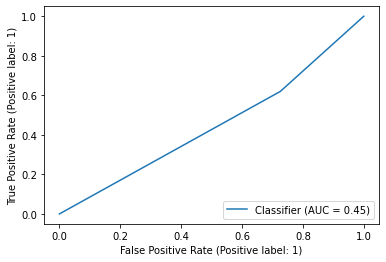

['model/randomforest_pipeline.pkl']

In [6]:
#Create a random forest pipeline
randomforest_pipeline = Pipeline(steps = [
    ('data_scaling', StandardScaler()),
    ('model', RandomForestClassifier(class_weight= "balanced"))
])
randomforest_param_grid = [
    {
        "model__n_estimators": np.arange(30,100,15),
        "model__criterion": ["gini","entropy"],
        "model__max_depth": np.arange(10,100,30),
        "model__min_samples_leaf": [3,6],
        "model__min_samples_split": [3,6]
        
    }
] 
tuned_model = cv_fit_search(randomforest_pipeline,randomforest_param_grid,X_train,y_train,X_val,y_val,10)
joblib.dump(tuned_model, 'model/randomforest_pipeline.pkl')

the best parametes are {'model__l2_regularization': 0, 'model__learning_rate': 0.05, 'model__loss': 'binary_crossentropy'}
Accuracy Score: 0.48120300751879697
ROC AUC Score: 0.4721717401181281
f1 Score: 0.5548387096774193


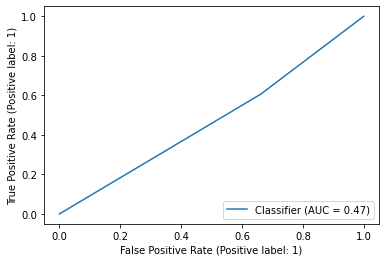

['model/boosting_pipeline.pkl']

In [7]:
# Lets try a boosting model now
# Due to the way boosting works, does not need weights to deal with imbalanced classes
from sklearn.ensemble import HistGradientBoostingClassifier
boostingPipeline = Pipeline(steps = [
    ('data_scaling', StandardScaler()),
    ('model', HistGradientBoostingClassifier())
])

boosting_param_grid = [
    {
        "model__loss": ["binary_crossentropy","auto"],
        "model__learning_rate": [0.01,0.05,0.1,0.5,1],
        "model__l2_regularization": [0,1]
    }
]   
tuned_model = cv_fit_search(boostingPipeline,boosting_param_grid,X_train,y_train,X_val,y_val,10)
joblib.dump(tuned_model, 'model/boosting_pipeline.pkl')

the best parametes are {'model__penalty': 'l1'}
Accuracy Score: 0.45112781954887216
ROC AUC Score: 0.45320308950477056
f1 Score: 0.45112781954887216


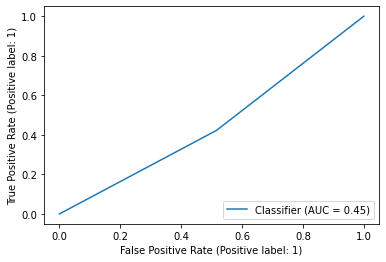

['model/lr_pipeline.pkl']

In [8]:
#logistic Regression with cross validation
from sklearn.linear_model import LogisticRegressionCV
lr_pipeline = Pipeline(steps = [
    ('data_scaling', StandardScaler()),
    ('model', LogisticRegressionCV(solver="liblinear",class_weight="balanced"))#saga solver works for all penalties
])

lr_param_grid = [
    {
        "model__penalty": ['l1', 'l2']
    }
]

tuned_model = cv_fit_search(lr_pipeline,lr_param_grid,X_train,y_train,X_val,y_val,10)
joblib.dump(tuned_model, 'model/lr_pipeline.pkl')

the best parametes are {'model__n_neighbors': 59}
Accuracy Score: 0.5639097744360902
ROC AUC Score: 0.5455474784189005
f1 Score: 0.6666666666666666


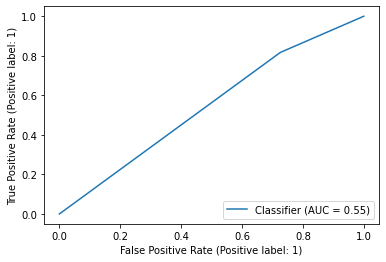

['model/knnc_pipeline.pkl']

In [10]:
#k nearest neighbors classifier
from sklearn.neighbors import KNeighborsClassifier

knnc_pipeline = Pipeline(steps = [
    ('data_scaling', StandardScaler()),
    ('model', KNeighborsClassifier())#10 cross validation
])

knnc_param_grid = [
    {
        "model__n_neighbors": np.arange(1,200)
    }
]

tuned_model = cv_fit_search(knnc_pipeline,knnc_param_grid,X_train,y_train,X_val,y_val,10)

joblib.dump(tuned_model, 'model/knnc_pipeline.pkl')


the best parametes are {'model__kernel': 'linear'}
Accuracy Score: 0.44360902255639095
ROC AUC Score: 0.4420717855520218
f1 Score: 0.4714285714285714


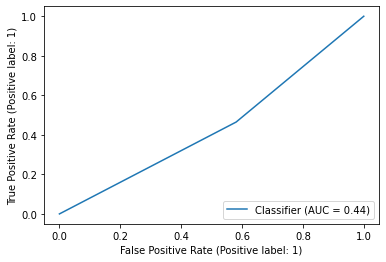

['model/svm_pipeline.pkl']

In [11]:
from sklearn.svm import SVC

svm_pipeline = Pipeline(steps = [
    ('data_scaling', StandardScaler()),
    ('model', SVC(class_weight="balanced"))#10 cross validation
])

svm_param_grid = [
    {
        "model__kernel": ['linear', 'poly', 'rbf']
    }
]

tuned_model = cv_fit_search(svm_pipeline,svm_param_grid,X_train,y_train,X_val,y_val,10)

joblib.dump(tuned_model, 'model/svm_pipeline.pkl')